In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from utils import aggregate_returns, get_first_and_last_day_in_period
from matplotlib.ticker import FuncFormatter

In [2]:
# User settings
lag = 0 # Trading lag (optional)

## Statistics for US Market data

In [3]:
df = pd.read_excel('data/USDaily.xlsx')

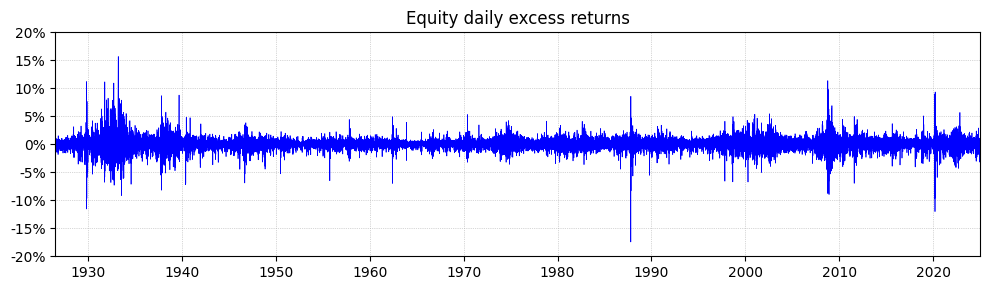

In [4]:
# Daily excess returns (Figure 3)
plt.figure(figsize=(10, 3))
plt.plot(df['Date'], df['xs_returns'], color='blue', linewidth=0.5)
plt.title('Equity daily excess returns')

# Force y-axis to show percentages
plt.ylim(-0.2, 0.2)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Force x-axis to span full desired range
start_date = pd.to_datetime('1926-07-01')
end_date = pd.to_datetime('2024-12-31')
plt.xlim(start_date, end_date)

# Add ticks every 10 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [5]:
print(df.loc[df['xs_returns'].idxmax(), 'Date'])
print(df.loc[df['xs_returns'].idxmin(), 'Date'])

1933-03-15 00:00:00
1987-10-19 00:00:00


In [6]:
monthly_returns, monthly_dates = aggregate_returns(df['xs_returns'], df['Date'], period='M')
monthly_rf, _ = aggregate_returns(df['rf'], df['Date'], period='M')
# Convert to DataFrame for easy plotting
monthly_df = pd.DataFrame({
    'Date': monthly_dates,
    'xs_returns': monthly_returns.flatten(),  
    'rf': monthly_rf.flatten()
})


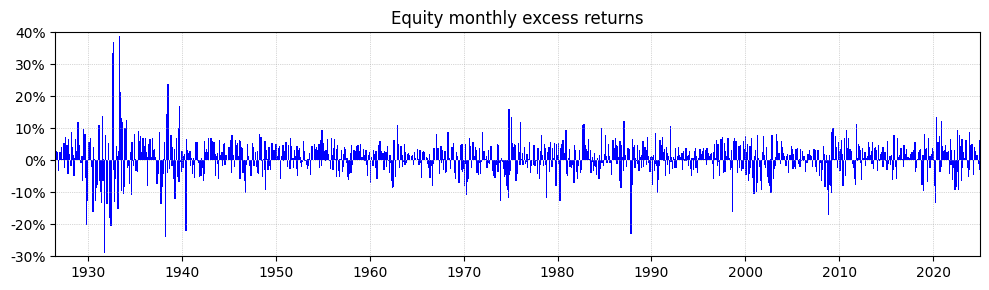

In [7]:
# Monthly excess returns (Figure 3)
plt.figure(figsize=(10, 3))
plt.bar(monthly_df['Date'], monthly_df['xs_returns'], width=50, color='blue', linewidth=0)

# Title and y-axis formatting
plt.title('Equity monthly excess returns')
plt.ylim(-0.3, 0.4)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# X-axis formatting
plt.xlim(pd.to_datetime('1926-07-01'), pd.to_datetime('2024-12-31'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [8]:
annual_returns, annual_dates = aggregate_returns(df['xs_returns'], df['Date'], period='Y')

annual_df = pd.DataFrame({
    'Date': annual_dates,
    'xs_returns': annual_returns.flatten()
})


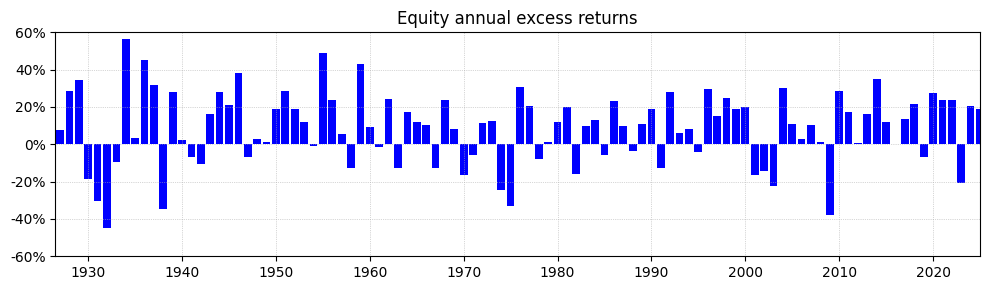

In [9]:
# Annual excess returns (Figure 3)
plt.figure(figsize=(10, 3))
plt.bar(annual_df['Date'], annual_df['xs_returns'], width=300, color='blue',linewidth=0)

plt.title('Equity annual excess returns')
plt.ylim(-0.6, 0.6)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Show ticks every 10 years
plt.xlim(pd.to_datetime('1926-07-01'), pd.to_datetime('2024-12-31'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


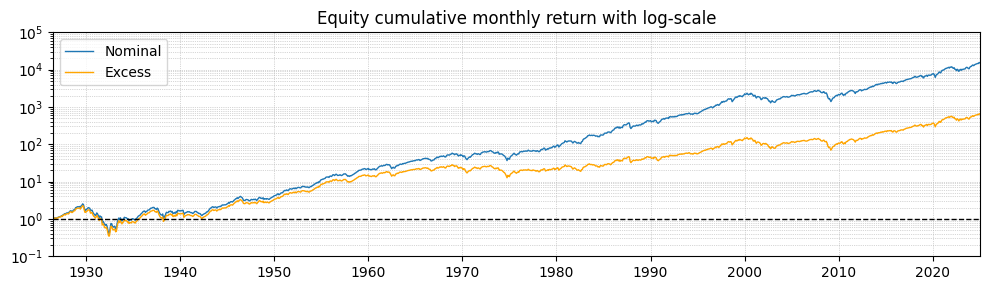

In [10]:
# Compute cumulative returns
cum_total = np.cumprod(1 + monthly_df['xs_returns'] + monthly_df['rf'])
cum_excess = np.cumprod(1 + monthly_df['xs_returns'])

# Create the plot (Figure 3)
fig, ax = plt.subplots(figsize=(10, 3))

# Plot cumulative returns using log scale
ax.semilogy(monthly_df['Date'], cum_total, color='tab:blue', label='Nominal', linewidth=1)
ax.semilogy(monthly_df['Date'], cum_excess, color='orange', label='Excess', linewidth=1)

# Add horizontal line at y = 1
ax.axhline(1, color='black', linestyle='--', linewidth=1)

# Title and axis formatting
ax.set_title('Equity cumulative monthly return with log-scale', fontsize=12)
ax.set_xlim(pd.to_datetime('1926-07-01'), pd.to_datetime('2024-12-31'))
ax.set_ylim(0.1, 1e5)
#ax.set_xlabel('Year')
#ax.set_ylabel('Cumulative Return (log scale)')

# Format x-axis ticks every 10 years
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Style
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

In [11]:
firstDayList, lastDayList = get_first_and_last_day_in_period(df['Date'], period = "M")
monthlyVar = np.zeros((len(firstDayList), 1))

for i in range(len(firstDayList)):
    first = max(firstDayList[i] - lag, 0)
    last = lastDayList[i] - lag

    # Get the daily returns for the window
    window = df['xs_returns'].iloc[first:last + 1]

    # Compute sample variance (per asset if 2D)
    monthlyVar[i, :] = np.var(window, axis=0, ddof=1)

monthly_df['variance'] = monthlyVar

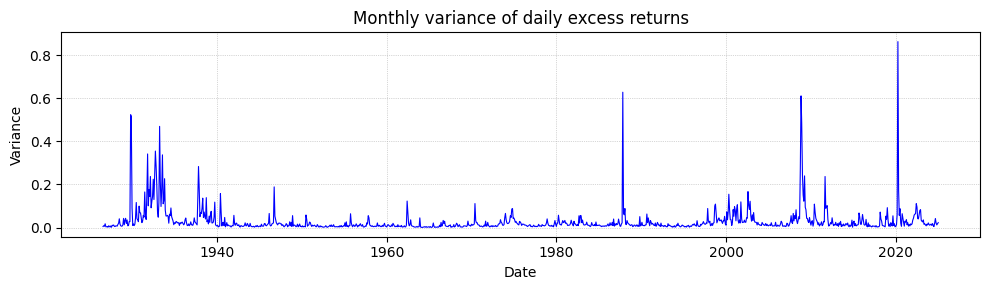

In [12]:
# Monthly variance (Not in paper)
plt.figure(figsize=(10, 3))
plt.plot(monthly_df['Date'], monthly_df['variance'] * 252, color='blue', linewidth=0.8)
plt.title('Monthly variance of daily excess returns')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [13]:
monthly_df['volatility'] = np.sqrt(monthly_df['variance'])  # Daily volatility
monthly_df['vol_lag'] = monthly_df['volatility'].shift(1)

monthly_df = monthly_df.dropna(subset=['vol_lag'])
monthly_df['vol_bucket'] = pd.qcut(monthly_df['vol_lag'], 5, labels=[1, 2, 3, 4, 5])

summary = monthly_df.groupby('vol_bucket', observed=True).agg(
    ann_return = ('xs_returns', lambda x: x.mean() * 12 * 100),             
    ann_vol    = ('xs_returns', lambda x: x.std(ddof=1) * np.sqrt(12) * 100)  
).reset_index()

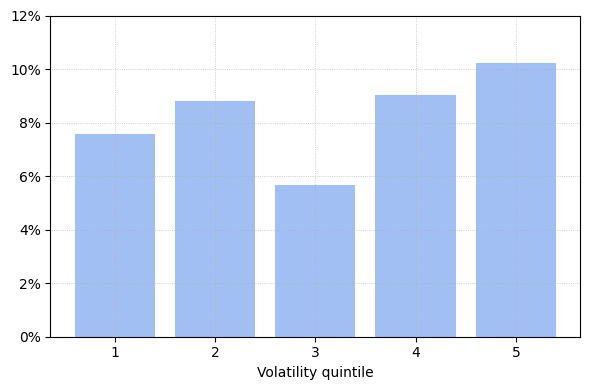

In [14]:
# Volatility quintile (Figure 4)
plt.figure(figsize=(6, 4))
plt.bar(summary['vol_bucket'].astype(str), summary['ann_return'], color='cornflowerblue', alpha=0.6)
plt.ylim(0, 12)
plt.xlabel('Volatility quintile')
plt.grid(True, linestyle=':', linewidth=0.5)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.tight_layout()
plt.show()

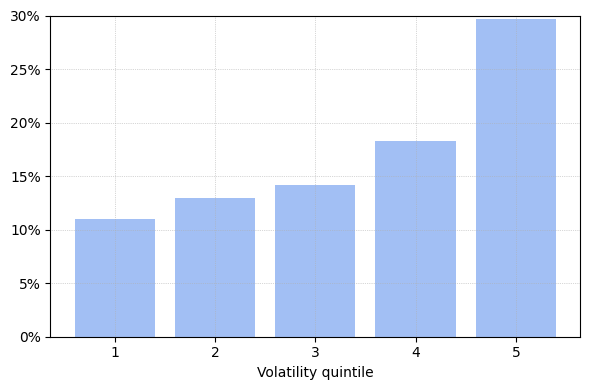

In [15]:
# Volatility quintile (Figure 4)
plt.figure(figsize=(6, 4))
plt.bar(summary['vol_bucket'].astype(str), summary['ann_vol'], color='cornflowerblue', alpha=0.6)
plt.ylim(0, 30)
plt.xlabel('Volatility quintile')
plt.grid(True, linestyle=':', linewidth=0.5)

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.tight_layout()
#plt.savefig('vol_quintile.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistics for US Equity 10 Industry Portfolios

In [16]:
df_industry = pd.read_excel('data/USIndustryDaily.xlsx')

In [17]:
# Get all columns that contain 'xs_returns_'
xs_cols = [col for col in df_industry.columns if 'xs_returns_' in col]

# Combine with the 'date' and 'rf' columns
selected_columns = ['Date', 'rf'] + xs_cols

# Extract the subset of the DataFrame
df_selected = df_industry[selected_columns]

In [18]:
# Select all return columns
xs_cols = [col for col in df_selected.columns if 'xs_returns_' in col]

# Get the start and end indices for each month
firstDayList, lastDayList = get_first_and_last_day_in_period(df['Date'], period="M")

# Preallocate a matrix to store variance (rows = months, columns = assets)
monthlyVar = np.zeros((len(firstDayList), len(xs_cols)))

# Loop over each month
for i in range(len(firstDayList)):
    first = max(firstDayList[i] - lag, 0)
    last = lastDayList[i] - lag

    # Get the daily returns for the month for all selected assets
    window = df_selected[xs_cols].iloc[first:last + 1]

    # Compute variance per asset across the window
    monthlyVar[i, :] = np.var(window, axis=0, ddof=1)

# Create a new DataFrame for monthly variance
monthly_var_df = pd.DataFrame(monthlyVar, columns=[col.replace('xs_returns_', 'var_') for col in xs_cols])

# Adding the corresponding dates (e.g., last day of each month)
monthly_var_df['Date'] = df_selected['Date'].iloc[lastDayList].values


In [19]:
cols = ['Date'] + [col for col in monthly_var_df.columns if col != 'Date']
monthly_var_df = monthly_var_df[cols]

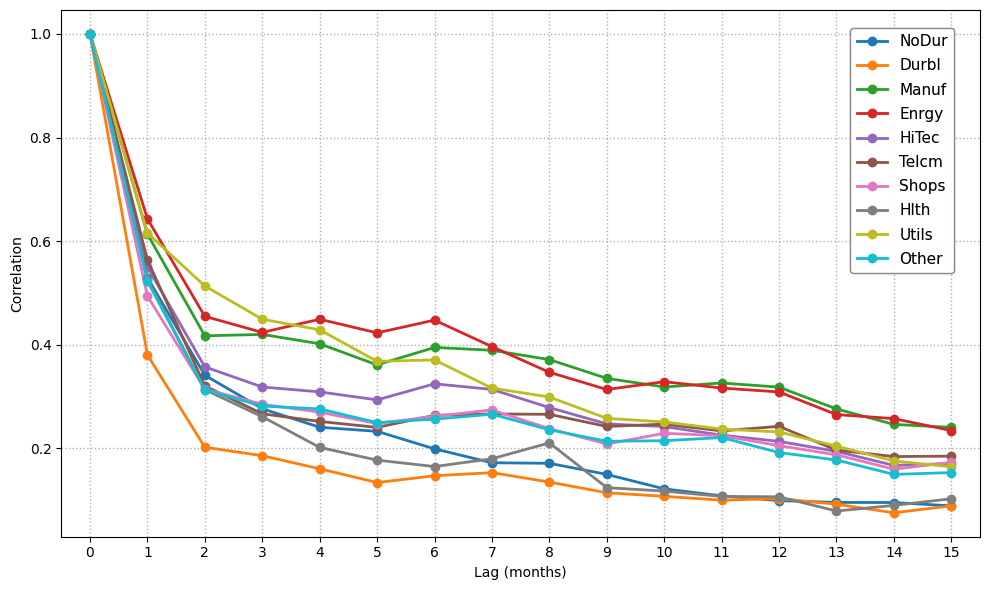

In [20]:
# Autocorrelation plot of industry portfolios (Figure 9)
# Maximum lag
max_lag = 15

# Extract variance columns
var_cols = [col for col in monthly_var_df.columns if col != 'Date']

# Compute autocorrelations
acf_dict = {
    col: [monthly_var_df[col].autocorr(lag=lag) for lag in range(max_lag + 1)]
    for col in var_cols
}

# Convert to DataFrame
acf_df = pd.DataFrame(acf_dict)
acf_df['Lag'] = range(max_lag + 1)

# Plot setup
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(var_cols)))  # up to 10 distinctive colors

# Plot each line and store for legend
lines = []
labels = []

for i, col in enumerate(var_cols):
    industry_name = col.replace('var_', '')
    line, = plt.plot(
        acf_df['Lag'],
        acf_df[col],
        color=colors[i],
        marker='o',
        linewidth=2,
        label=industry_name
    )
    lines.append(line)
    labels.append(industry_name)

# Add legend inside the plot
plt.legend(
    handles=lines,
    labels=labels,
    loc='upper right',
    fontsize=11,             
    frameon=True,            
    framealpha=0.8,          
    facecolor='white',       
    edgecolor='gray',        
    bbox_to_anchor=(0.98, 0.98),  
    labelspacing=0.6         
)
plt.gca().add_artist(plt.gca().get_legend())

# X-axis and formatting
plt.xticks(np.arange(0, max_lag + 1, 1))
plt.xlim(-0.5, max_lag + 0.5)
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True, linestyle=':', linewidth=1)
plt.tight_layout()
plt.show()